# Generative Models

## GANs & VAE

### HW4

**Full Name:** Mehdi Jamalkhah

**SID:**

### Local Setup

In [2]:
import gdown
VAR_ROOT = "vars/gan-vae"
gdown.download_folder("https://drive.google.com/drive/folders/11-93r5ryr-n5hYK_9LEs8GHSvTHBQwe_?usp=sharing", output=VAR_ROOT, quiet=True)

['vars/gan-vae/vae.pt']

### Google Colab Setup

In [3]:
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DL/HW4'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
os.chdir(GOOGLE_DRIVE_PATH)
print(os.listdir('./'))

### Save/Load

In [11]:
import torch

def load(filename):
    return torch.load(VAR_ROOT + '/' + filename + '.pt', map_location=torch.device('cpu'))

def save(object, filename):
    filename = VAR_ROOT + '/' + filename + '.pt'
    if isinstance(object, torch.nn.Module):
        torch.save(object.state_dict(), filename)
    else:
        torch.save(object, filename)

In this notebook, we are going to implement Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN) on the MNIST dataset. VAEs learn a latent variable model from input data. They sample from this distribution and decode it to generate new data. GANs uses a generator to make images based on a prior distribution.


+ Complete the `TODO` parts in the code accordingly.

In [1]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

CUDA = 'cuda'
DEVICE = CUDA if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

# Dataset

We will be using MNIST dataset which consists of 60000 data. We split them into train and validation sets, each having 50000 and 10000 data respectively.

In [2]:
transformation = transforms.Compose([
        transforms.ToTensor(),
    ])

In [3]:
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

train_data, valid_data = random_split(mnist_data, [50000, 10000])

In [4]:
num_threads = 2
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)

val_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_threads)

In [5]:
def show_image(img, label=None):
    plt.imshow(img[0], cmap='gray')
    plt.yticks([])
    plt.xticks([])
    if label != None:
        plt.title(f"L: {label}")

# VAE

Variational Autoencoders (VAEs) are a class of generative models that aim to learn the probability distribution of a given dataset in order to generate new data points that resemble the original data. They use and encoder that embeds each data to a smaller latent space and a decoder that tries to generate the original image, given this latent space.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png)
---


In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
        self.relu2 = nn.ReLU()

        self.mean = nn.Linear(latent_dim, latent_dim)
        self.log_var = nn.Linear(latent_dim, latent_dim)


    def forward(self, x):
        # Convert input `x` to mean and log variance of latent
        # space which is then used to sample data for the decoder.
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)

        z_mean = self.mean(x)
        z_log_var = self.log_var(x)

        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu2 = nn.ReLU()


    def forward(self, z):
        # Decode the latent vector `z` to images.
        x = self.fc1(z)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        return x

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def rand(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Using the encoder and decoder you have defined, encode the
        # image to the latent space and then reconstruct it.
        # Use the reparameterization trick to ensure gradient flow.
        image_shape = x.shape
        z_mean, z_log_var = self.encoder(x.view(x.shape[0], -1))
        z = self.rand(z_mean, z_log_var)
        image = self.decoder(z).view(image_shape)
        return image, z_mean, z_log_var

In [9]:
def reconstruct_images(vae, images):
    with torch.no_grad():
        recon_images, _, _ = vae(images)
    return recon_images

In [10]:
def loss_function(x, recon_x, mu, logvar):
    recon_loss = nn.MSELoss(reduction="sum")(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD

In [13]:
def train_vae(dataloader, model, learning_rate=1e-4, num_epochs=100):
    # Define the loss fc, optimizer and VAE model.
    criterion = loss_function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    sample_images, labels = next(iter(val_loader))
    sample_images = sample_images.to(DEVICE)

    recon_images = []
    
    num_samples = 4
    plt.figure(figsize=(4, 1))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        show_image(sample_images[i].cpu(), label=labels[i])
        if i == 0:
            plt.ylabel("Original")
    plt.show()
    

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (data, _) in pbar:
                data = data.to(DEVICE)
                output = model(data)
                loss = criterion(data, *output)
    
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss
                pbar.set_description(f'Epoch ({epoch}/{num_epochs}): Loss: {train_loss / len(dataloader.dataset):.4f}')

        # Reconstruct `sample_images` and plot first 4 images after each epoch
        # This is used to visualize the progress
        
        plt.figure(figsize=(4, 1))
        recon_image = reconstruct_images(model, sample_images)
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            show_image(recon_image[i].cpu())
        plt.show()

    return model

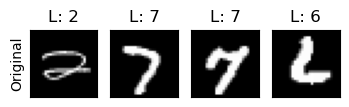

  0%|          | 0/1563 [00:00<?, ?it/s]

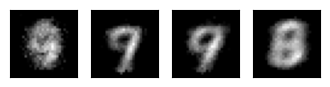

  0%|          | 0/1563 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
input_dim=784
hidden_dim=256
latent_dim=8

model = VAE(latent_dim=latent_dim, hidden_dim=hidden_dim, input_dim=input_dim).to(DEVICE)

if DEVICE != CUDA:
    model = train_vae(train_loader, model)
    save(model, "vae")
else:
    model.load_state_dict(load('vae'))

# GAN

GANs consist of two models: a generator and a discriminator. The generator creates new data points, and the discriminator evaluates them, trying to distinguish between real and generated (fake) data points. The training process involves updating the generator to produce more realistic data, as judged by the discriminator, and simultaneously updating the discriminator to get better at distinguishing real from fake. This adversarial process leads to improvements in both models, with the generator producing highly realistic data points as a result.

In [15]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, img_shape):
        super(Generator, self).__init__()

        self.img_shape = img_shape
        
        self.img_dim = 1
        for dim in img_shape:
            self.img_dim *= dim

        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.img_dim),
            nn.ReLU() 
        )

    def forward(self, z):
        # generate an image using `z` vector, sampled
        # from a prior distribution.
        # Reshape the result to the shape of original images        
        img = self.model(z).view(z.shape[0], *self.img_shape)
        
        return img
    
    def generator_block(self, in_dimension, out_dimention):
        return nn.Sequential(
            nn.Linear(in_dimension, out_dimention),
            nn.BatchNorm1d(out_dimention),
            nn.ReLU()
        )

class Discriminator(nn.Module):
    def __init__(self, img_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            self.discriminator_block(img_dim, hidden_dim),
            self.discriminator_block(hidden_dim, 1)
        )

    def forward(self, img):
        # Predict whether each image in `img` is real or fake.
        
        x = self.model(img.view(img.shape[0], -1))
        return x
    
    def discriminator_block(self, in_dimension, out_dimension):
      return nn.Sequential(
           nn.Linear(in_dimension, out_dimension),
           nn.LeakyReLU(0.2, inplace=True)
      )

In [16]:
def get_disc_loss(gen, disc, real, criterion, latent_dim, batch_size):
    noise = torch.randn(batch_size, latent_dim, device=DEVICE)
    fake = gen(noise)
    fake_pred = disc(fake)
    real_pred = disc(real)
    
    fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))
    real_loss = criterion(real_pred, torch.ones_like(real_pred))
    
    disc_loss = (fake_loss + real_loss) / 2
    return disc_loss
    
def get_gen_loss(gen, disc, criterion, latent_dim, batch_size):
    noise = torch.randn(batch_size, latent_dim, device=DEVICE)
    fake = gen(noise)
    fake_pred = disc(fake)
    
    gen_loss = criterion(fake_pred, torch.ones_like(fake_pred))
    return gen_loss, fake

In [17]:
def train_gan(generator, discriminator, dataloader, latent_dim, batch_size, learning_rate=3e-4, num_epochs=100):
    criterion = nn.BCEWithLogitsLoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (imgs, _) in pbar:
                imgs = imgs.to(DEVICE)

                optimizer_D.zero_grad()
                disc_loss = get_disc_loss(generator, discriminator, imgs, criterion, latent_dim, batch_size)
                disc_loss.backward()
                optimizer_D.step()
                
                optimizer_G.zero_grad()
                gen_loss, gen_imgs = get_gen_loss(generator, discriminator, criterion, latent_dim, batch_size)
                gen_loss.backward()
                optimizer_G.step()
                
                pbar.set_description("[epoch: {}/{}] [D loss: {:.4f}] [G loss: {:.4f}]".format(epoch, num_epochs, disc_loss.item(), gen_loss.item()))

        # TODO
        # Plot generated images after each epoch
        plt.figure(figsize=(batch_size, 2))
        for i, img in enumerate(gen_imgs):
            plt.subplot(1, batch_size, i + 1)
            show_image(img.detach())
        plt.show()

    return generator, discriminator

  0%|          | 0/1563 [00:00<?, ?it/s]

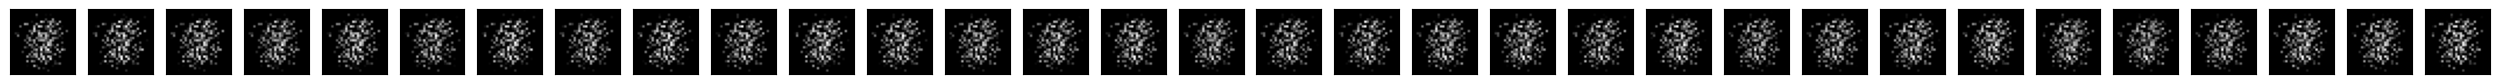

  0%|          | 0/1563 [00:00<?, ?it/s]

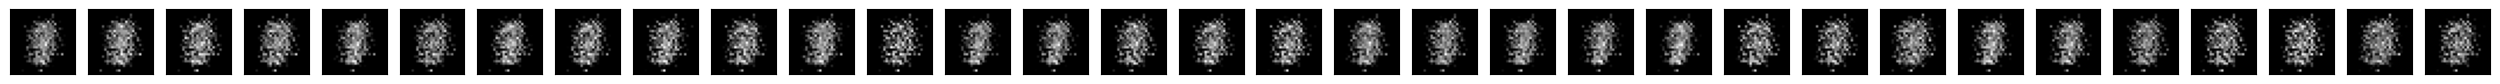

  0%|          | 0/1563 [00:00<?, ?it/s]

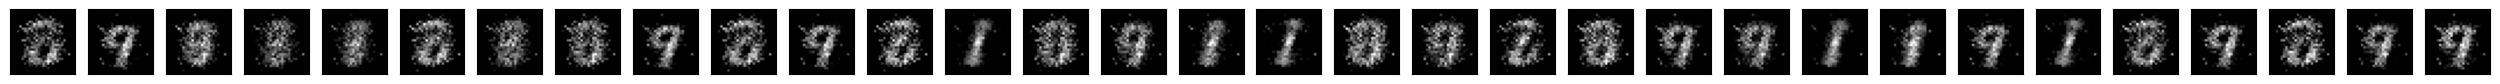

  0%|          | 0/1563 [00:00<?, ?it/s]

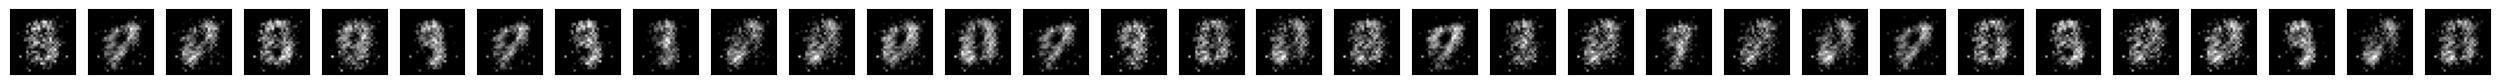

  0%|          | 0/1563 [00:00<?, ?it/s]

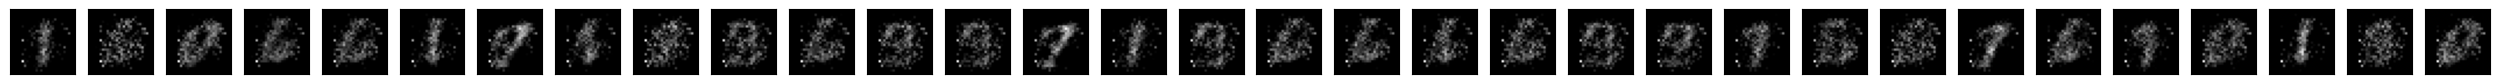

  0%|          | 0/1563 [00:00<?, ?it/s]

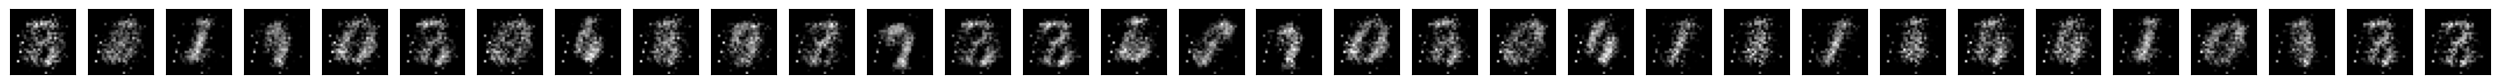

  0%|          | 0/1563 [00:00<?, ?it/s]

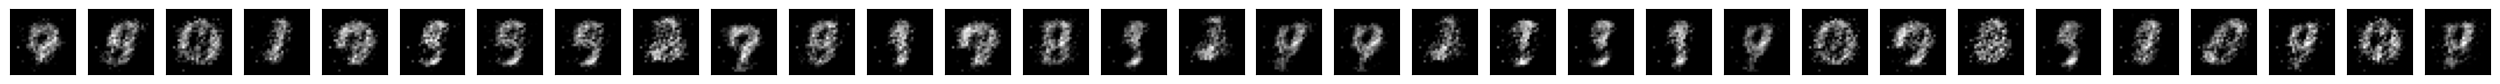

  0%|          | 0/1563 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
img_shape=(1, 28, 28)

generator = Generator(latent_dim, 256, img_shape).to(DEVICE)
discriminator = Discriminator(generator.img_dim, 256).to(DEVICE)
if DEVICE == CUDA:
    generator, discriminator = train_gan(generator, discriminator, train_loader, latent_dim=8, batch_size=batch_size)
    save(generator, 'generator')
    save(discriminator, 'discriminator')
else:
    generator.load_state_dict(load('generator'))
    discriminator.load_state_dict(load('discriminator'))

# Compare

Use validation dataset to plot and compare the results of your trained models.

In [ ]:
# TODO
# Comparison of the generated images